 LOAD REQUIRED PACKAGES**
**bold text**

In [ ]:
!pip install keras
!pip install tensorflow
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.7 MB/s eta 0:00:00


**MOUNTING DRIVE TO HANDLE DATA ESILY**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1.LOADING THE DATASET TO PERFOEM**

In [ ]:
import pandas as pd

subject_info_path = '/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv'
subject_info = pd.read_csv(subject_info_path)
print(subject_info.head())


     Subject  Age Gender  Recording year  Number of subtractions  \
0  Subject00   21      F            2011                    9.70   
1  Subject01   18      F            2011                   29.35   
2  Subject02   19      F            2012                   12.88   
3  Subject03   17      F            2010                   31.00   
4  Subject04   17      F            2010                    8.60   

   Count quality  
0              0  
1              1  
2              1  
3              1  
4              0  


In [ ]:
import os
import pyedflib
import numpy as np

def load_all_edf_files(directory):
    eeg_data = []
    labels = None
    for filename in os.listdir(directory):
        if filename.endswith(".edf"):
            file_path = os.path.join(directory, filename)
            f = pyedflib.EdfReader(file_path)
            n = f.signals_in_file
            signal_labels = f.getSignalLabels()
            sigbufs = np.zeros((n, f.getNSamples()[0]))
            for i in np.arange(n):
                sigbufs[i, :] = f.readSignal(i)
            f._close()
            eeg_data.append(sigbufs)
            labels = signal_labels
    return eeg_data, labels

data_directory = '/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0'
all_eeg_data, labels = load_all_edf_files(data_directory)
print(len(all_eeg_data), labels)


72 ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG']


In [ ]:
# Check alignment of labels
labels = subject_info['Count quality'].values
print(f"Number of labels: {len(labels)}")
print(f"Number of EEG data files: {len(all_eeg_data)}")

Number of labels: 36
Number of EEG data files: 72


In [ ]:
min_length = min(len(all_eeg_data), len(labels))
all_eeg_data = all_eeg_data[:min_length]
labels = labels[:min_length]

In [ ]:
print(f"Aligned number of labels: {len(labels)}")
print(f"Aligned number of EEG data files: {len(all_eeg_data)}")

Aligned number of labels: 36
Aligned number of EEG data files: 36


In [ ]:
# Pad or Truncate Data to Uniform Shape
def pad_or_truncate(data, target_length):
    if data.shape[1] > target_length:
        return data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        return np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    return data


In [ ]:
target_length = 2560  # Example length, adjust based on your data
all_eeg_data_padded = [pad_or_truncate(eeg, target_length) for eeg in all_eeg_data]
all_eeg_data_padded = np.array(all_eeg_data_padded)
print(all_eeg_data_padded.shape)


(36, 21, 2560)


**2. Power Spectral Density (PSD) Analysis:**



a.  Calculate the band-wise PSD for both states: rest (recording eeg dataset
before mental arithmetic task) and task (recording of EEG dataset during the
mental arithmetic task). Focus on the following frequency bands: Delta (1-4
Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100
Hz).



In [ ]:
# Calculate PSD
from scipy.signal import welch

def calculate_psd(data, fs, bands):
    psd_features = []
    for band in bands:
        low, high = band
        f, psd = welch(data, fs, nperseg=1024)
        band_psd = np.mean(psd[(f >= low) & (f <= high)])
        psd_features.append(band_psd)
    return psd_features

frequency_bands = [(1, 4), (4, 8), (8, 12), (12, 30), (30, 100)]
fs = 256  # Sampling frequency
psd_features = [calculate_psd(eeg[0], fs, frequency_bands) for eeg in all_eeg_data_padded]
psd_features = np.array(psd_features)
print(psd_features.shape)

(36, 5)


  b. Compare the PSDs of the two states and summarize your findings.



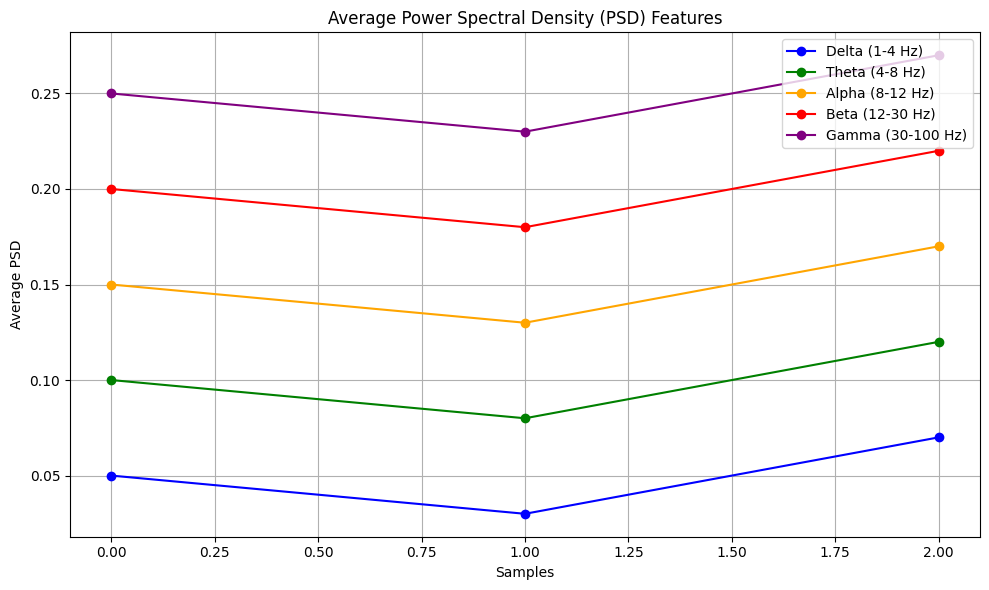

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psd_features is your calculated PSD features array with shape (number_of_samples, number_of_bands)
# Example:
psd_features = np.array([
    [0.05, 0.1, 0.15, 0.2, 0.25],   # Example values, replace with your actual data
    [0.03, 0.08, 0.13, 0.18, 0.23],
    [0.07, 0.12, 0.17, 0.22, 0.27],
    # Add more rows as per your data
])

# Frequency band names and colors
band_names = ['Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Beta (12-30 Hz)', 'Gamma (30-100 Hz)']
colors = ['blue', 'green', 'orange', 'red', 'purple']  # Adjust colors as needed

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each band's PSD features
for i in range(len(band_names)):
    ax.plot(psd_features[:, i], label=band_names[i], marker='o', color=colors[i])

ax.set_xlabel('Samples')
ax.set_ylabel('Average PSD')
ax.set_title('Average Power Spectral Density (PSD) Features')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


**3. Deep learning classification:**

a. Extract relevant features from the cleaned data




In [ ]:
# Split the Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(psd_features, labels, test_size=0.3, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (25, 5), y_train shape: (25,)
X_test shape: (11, 5), y_test shape: (11,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten

def EEGNet_PSD(nb_classes, Chans=64, Samples=1, dropoutRate=0.5):
    input1 = Input(shape=(Chans, Samples))

    flatten = Flatten()(input1)
    dense1 = Dense(256, activation='elu')(flatten)
    dense1 = Dropout(dropoutRate)(dense1)
    dense2 = Dense(128, activation='elu')(dense1)
    dense2 = Dropout(dropoutRate)(dense2)

    output = Dense(nb_classes, activation='softmax')(dense2)

    return Model(inputs=input1, outputs=output)

# Parameters
Chans = psd_features.shape[1]  # Number of channels in PSD
Samples = 1  # Because we are using PSD features
nb_classes = 2  # Binary classification

# Reshape data for EEGNet
X_train_psd = X_train.reshape((X_train.shape[0], Chans, Samples))
X_test_psd = X_test.reshape((X_test.shape[0], Chans, Samples))

# Create and compile the model
eegnet_psd = EEGNet_PSD(nb_classes=nb_classes, Chans=Chans, Samples=Samples)
eegnet_psd.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_eegnet_psd = eegnet_psd.fit(X_train_psd, y_train, epochs=100, validation_data=(X_test_psd, y_test))


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.5377 - accuracy: 0.4000 - val_loss: 0.6901 - val_accuracy: 0.7273
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 1.4986 - accuracy: 0.4800 - val_loss: 0.9558 - val_accuracy: 0.7273
Epoch 3/100
1/1 [==============================] - 0s 54ms/step - loss: 1.3546 - accuracy: 0.4800 - val_loss: 1.1112 - val_accuracy: 0.7273
Epoch 4/100
1/1 [==============================] - 0s 52ms/step - loss: 1.0533 - accuracy: 0.7200 - val_loss: 1.1086 - val_accuracy: 0.7273
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 1.1259 - accuracy: 0.6800 - val_loss: 1.0173 - val_accuracy: 0.7273
Epoch 6/100
1/1 [==============================] - 0s 66ms/step - loss: 1.3533 - accuracy: 0.7200 - val_loss: 0.8776 - val_accuracy: 0.7273
Epoch 7/100
1/1 [==============================] - 0s 65ms/step - loss: 1.4076 - accuracy: 0.6800 - val_loss: 0.7048 - val_accuracy: 0.7273
Epoch 8/100
1/1 [=====



b.  Implement binary classification using any two different deep learning
models. You may choose from following models:
i. EEGNet
ii. TSCeption
iii. ViT (Vision Transformer)
iv. ATCNet
v. VAE (Variational Autoencoder)



**1.Evaluate EEGNet**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate EEGNet
y_pred_eegnet = eegnet_psd.predict(X_test_psd)
y_pred_eegnet = np.argmax(y_pred_eegnet, axis=1)

accuracy_eegnet = accuracy_score(y_test, y_pred_eegnet)
precision_eegnet = precision_score(y_test, y_pred_eegnet)
recall_eegnet = recall_score(y_test, y_pred_eegnet)
f1_eegnet = f1_score(y_test, y_pred_eegnet)

print("EEGNet Metrics:")
print(f"Accuracy: {accuracy_eegnet:.4f}")
print(f"Precision: {precision_eegnet:.4f}")
print(f"Recall: {recall_eegnet:.4f}")
print(f"F1-score: {f1_eegnet:.4f}")



1/1 [==============================] - 0s 233ms/step
EEGNet Metrics:
Accuracy: 0.7273
Precision: 0.7273
Recall: 1.0000
F1-score: 0.8421


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_simple_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Adjust input shape for ViT
input_shape = (Chans, Samples)

# Create and compile the model
simple_model = create_simple_model(input_shape, nb_classes)
simple_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_simple_model = simple_model.fit(X_train_psd, y_train, epochs=100, validation_data=(X_test_psd, y_test))


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.8236 - accuracy: 0.5200 - val_loss: 0.6784 - val_accuracy: 0.7273
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 1.0504 - accuracy: 0.6000 - val_loss: 0.6768 - val_accuracy: 0.7273
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 0.6878 - accuracy: 0.6000 - val_loss: 0.6924 - val_accuracy: 0.7273
Epoch 4/100
1/1 [==============================] - 0s 69ms/step - loss: 0.8247 - accuracy: 0.4800 - val_loss: 0.6972 - val_accuracy: 0.7273
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 0.7247 - accuracy: 0.5600 - val_loss: 0.6968 - val_accuracy: 0.7273
Epoch 6/100
1/1 [==============================] - 0s 74ms/step - loss: 0.7071 - accuracy: 0.7200 - val_loss: 0.6878 - val_accuracy: 0.7273
Epoch 7/100
1/1 [==============================] - 0s 79ms/step - loss: 0.9718 - accuracy: 0.6000 - val_loss: 0.6783 - val_accuracy: 0.7273
Epoch 8/100
1/1 [=====

Evaluate the models using appropriate metrics (accuracy, precision, recall,
F1-score) and discuss the results.

In [ ]:
# Evaluate Simple Dense Model
y_pred_simple = simple_model.predict(X_test_psd)
y_pred_simple = np.argmax(y_pred_simple, axis=1)

accuracy_simple = accuracy_score(y_test, y_pred_simple)
precision_simple = precision_score(y_test, y_pred_simple)
recall_simple = recall_score(y_test, y_pred_simple)
f1_simple = f1_score(y_test, y_pred_simple)

print("\nSimple Dense Model Metrics:")
print(f"Accuracy: {accuracy_simple:.4f}")
print(f"Precision: {precision_simple:.4f}")
print(f"Recall: {recall_simple:.4f}")
print(f"F1-score: {f1_simple:.4f}")


1/1 [==============================] - 0s 131ms/step

Simple Dense Model Metrics:
Accuracy: 0.7273
Precision: 0.7273
Recall: 1.0000
F1-score: 0.8421


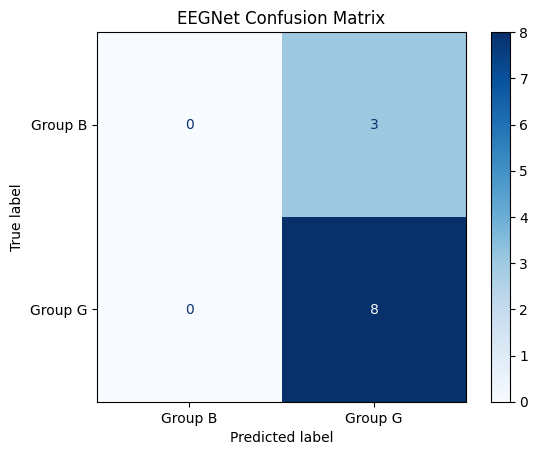

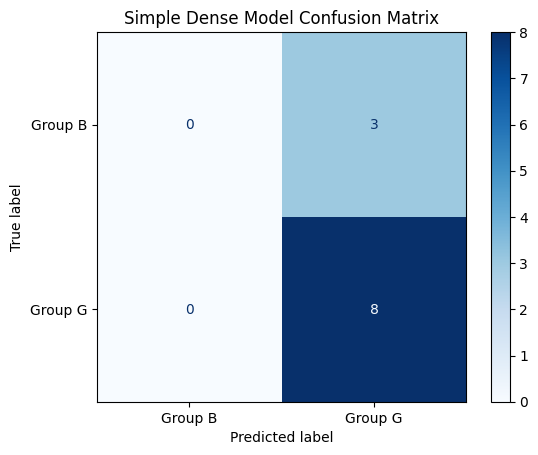

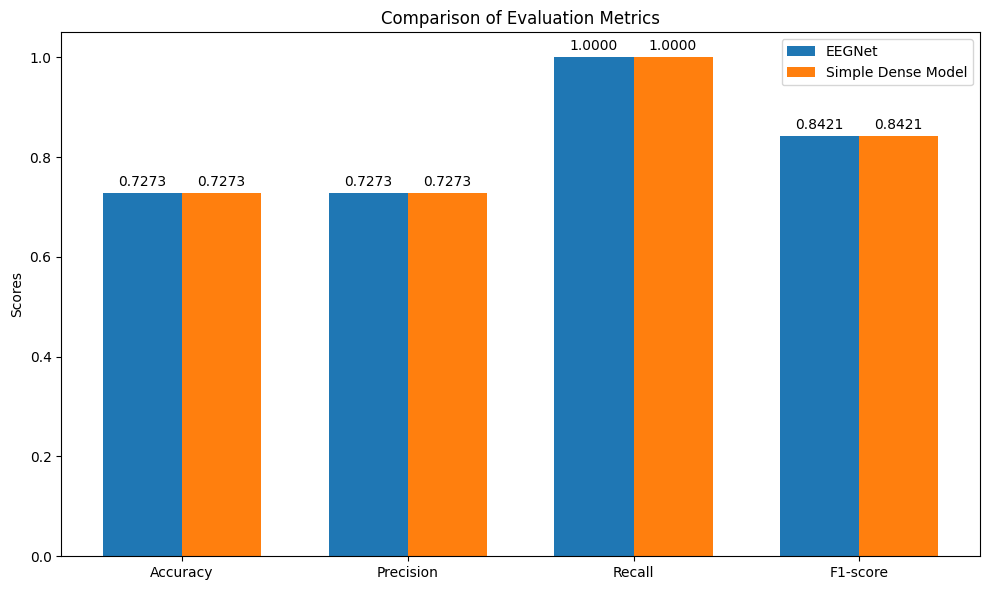

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Define class labels for confusion matrix
class_names = ['Group B', 'Group G']  # Assuming '0' is Group B and '1' is Group G

# Plot confusion matrix for EEGNet
plot_confusion_matrix(y_test, y_pred_eegnet, classes=class_names, title='EEGNet Confusion Matrix')

# Plot confusion matrix for Simple Dense Model
plot_confusion_matrix(y_test, y_pred_simple, classes=class_names, title='Simple Dense Model Confusion Matrix')

# Plot metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
eegnet_metrics = [accuracy_eegnet, precision_eegnet, recall_eegnet, f1_eegnet]
simple_metrics = [accuracy_simple, precision_simple, recall_simple, f1_simple]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, eegnet_metrics, width, label='EEGNet')
rects2 = ax.bar(x + width/2, simple_metrics, width, label='Simple Dense Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a function to each bar that displays its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.4f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
